# Beta-Binomial E-Process for Safe Testing: Tutorial

This notebook demonstrates how to use the **beta-binomial e-process** for safe testing of two proportions in the EarlySign framework. 

## Overview

Safe testing provides **anytime-valid** statistical inference using e-values, which offer:
- No need for multiple testing corrections
- Valid stopping at any time during data collection
- Exact Type I error control with threshold 1/α

We'll explore:
1. **Mathematical foundations** of the beta-binomial e-process
2. **Practical implementation** using EarlySign components
3. **Sequential analysis** with simulated experiments
4. **Comparison** with traditional group sequential methods
5. **Visualization** of e-value evolution over time

## Key Concepts

- **E-values**: Random variables with E[E] ≤ 1 under the null hypothesis
- **Beta-binomial model**: Uses conjugate priors for robust inference
- **Anytime validity**: Results remain valid regardless of stopping time
- **Event sourcing**: Complete audit trail of all analyses

This tutorial demonstrates EarlySign's **experiment interface** (`TwoPropExperiment`), which provides an intuitive way to conduct safe testing:

- ✅ **Easy setup** with `TwoPropExperiment(method="safe_testing", alpha_total=0.05, ...)`
- ✅ **Natural data registration** with `experiment.add_observations(...)`  
- ✅ **One-step analysis** with `result = experiment.analyze()`
- ✅ **Clean results** through structured `AnalysisResult` objects
- ✅ **Full event-sourcing** maintained for audit trails and advanced use

This eliminates manual `ledger.write_event()` calls while preserving the complete event-driven architecture underneath.

---

In [ ]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import betaln
import math
from typing import List, Tuple

# EarlySign business-oriented facade API - all A/B testing functionality unified
from earlysign.api.ab_test import guardrail_monitoring
from earlysign.backends.polars.ledger import PolarsLedger
from earlysign.runners import SequentialRunner
from earlysign.core.names import Namespace

# Legacy components (for advanced use)
from earlysign.methods.safe_testing.two_proportions import (
    BetaBinomialEValue,
    SafeThreshold,
    SafeSignaler,
)
from earlysign.schemes.two_proportions.reduce import reduce_counts

# Configure plotting
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 12

print("Libraries imported successfully!")
print("EarlySign version: Unified A/B Testing API with Business-Oriented Facade")

Libraries imported successfully!
EarlySign version: Safe Testing Tutorial


## 1. Mathematical Background

### The Beta-Binomial E-Process

For testing **H₀: pₐ = pᵦ** vs **H₁: pₐ ≠ pᵦ** with two binomial populations:

- **Group A**: X_A ~ Binomial(n_A, p_A)  
- **Group B**: X_B ~ Binomial(n_B, p_B)

The **beta-binomial e-process** uses conjugate beta priors:
- Under H₁: p_A ~ Beta(α_A, β_A), p_B ~ Beta(α_B, β_B) independently
- Under H₀: p_A = p_B = p ~ Beta(1, 1) (uniform prior)

### E-Value Formula

The e-value at time n is the **Bayes factor**:

```
E_n = P(data | H₁) / P(data | H₀)
```

For beta-binomial model:
```
log E_n = log B(α_A + x_A, β_A + n_A - x_A) + log B(α_B + x_B, β_B + n_B - x_B) 
          - log B(1 + x_total, 1 + n_total - x_total)
          - log B(α_A, β_A) - log B(α_B, β_B) + log B(1, 1)
```

where B(a,b) is the beta function.

### Anytime Validity

**Key Property**: Under H₀, E[E_τ] ≤ 1 for any stopping time τ

This gives **exact Type I error control**:
```
P(E_τ ≥ 1/α for some τ) ≤ α
```

No multiple testing correction needed! 🎉

In [2]:
# Helper function to demonstrate e-value calculation
def compute_beta_binomial_evalue(mA, nA, mB, nB, alpha_prior=1.0, beta_prior=1.0):
    """Compute e-value for beta-binomial test."""
    if min(nA, nB) == 0:
        return 0.0

    # Alternative: independent beta-binomial likelihoods
    log_alt_A = betaln(alpha_prior + mA, beta_prior + nA - mA) - betaln(
        alpha_prior, beta_prior
    )
    log_alt_B = betaln(alpha_prior + mB, beta_prior + nB - mB) - betaln(
        alpha_prior, beta_prior
    )
    log_alternative = log_alt_A + log_alt_B

    # Null: pooled data with uniform prior
    m_pool = mA + mB
    n_pool = nA + nB
    log_null = betaln(1 + m_pool, 1 + n_pool - m_pool) - betaln(1, 1)

    log_e_value = log_alternative - log_null
    return math.exp(log_e_value) if log_e_value < 100 else float("inf")


# Example calculation
mA, nA = 8, 20  # 8 successes out of 20 trials in group A
mB, nB = 2, 20  # 2 successes out of 20 trials in group B

e_value = compute_beta_binomial_evalue(mA, nA, mB, nB)
threshold = 1 / 0.05  # For α = 0.05

print(f"Group A: {mA}/{nA} successes ({mA/nA:.1%})")
print(f"Group B: {mB}/{nB} successes ({mB/nB:.1%})")
print(f"E-value: {e_value:.2f}")
print(f"Threshold (1/α): {threshold:.1f}")
print(f"Significant: {'Yes' if e_value >= threshold else 'No'}")

# Traditional z-test for comparison
pA_hat, pB_hat = mA / nA, mB / nB
p_pool = (mA + mB) / (nA + nB)
se = math.sqrt(p_pool * (1 - p_pool) * (1 / nA + 1 / nB))
z_stat = (pB_hat - pA_hat) / se
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"\nTraditional z-test:")
print(f"Z-statistic: {z_stat:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant (p < 0.05): {'Yes' if p_value < 0.05 else 'No'}")

Group A: 8/20 successes (40.0%)
Group B: 2/20 successes (10.0%)
E-value: 3.29
Threshold (1/α): 20.0
Significant: No

Traditional z-test:
Z-statistic: -2.19
P-value: 0.0285
Significant (p < 0.05): Yes


## 2. EarlySign Framework Demo

Now let's see how to use the **EarlySign event-sourcing framework** for safe testing. 

The framework provides:
- **Event-driven architecture**: All analyses are recorded as events
- **Component-based design**: Modular statistics, criteria, and signalers  
- **Complete audit trail**: Full reproducibility and regulatory compliance
- **Backend agnostic**: Works with various storage backends

In [ ]:
# Create a portable safe testing module
safe_module = TwoPropSafeModule(
    experiment_id="safe_test_demo", alpha_total=0.05, alpha_prior=1.0, beta_prior=1.0
)

# Create runner with Polars backend
runner = SequentialRunner(safe_module, PolarsLedger())

print("=== Safe Testing Module Configuration ===")
print(f"📦 Module: {safe_module.__class__.__name__}")
print(f"🏃 Runner: {runner.__class__.__name__}")
print(f"⚙️  Backend: {type(runner._ledger).__name__}")
print(f"Alpha level: {safe_module.alpha_total}")
print(f"Prior parameters: α={safe_module.alpha_prior}, β={safe_module.beta_prior}")

# Add first observation batch: Group A performing better
print("\n=== Adding Observations ===")
print("Group A: 8/10 successes (80%)")
print("Group B: 2/10 successes (20%)")

runner.add_observations(
    group_a_success=8, group_a_total=10, group_b_success=2, group_b_total=10
)

# Run the analysis
result = runner.analyze()

print("\n=== Analysis Results ===")
print(f"E-value: {result.statistic_value:.2f}")
print(f"Threshold (1/α): {result.threshold_value:.1f}")
print(f"Decision: {'🛑 STOP' if result.should_stop else '✅ Continue'}")
print(f"Group A rate: {result.group_a_rate:.1%}")
print(f"Group B rate: {result.group_b_rate:.1%}")
print(f"Log E-value: {result.additional_metrics.get('log_e_value', 'N/A'):.2f}")

# Show runner summary
summary = runner.get_summary()
print(f"\n📊 Runner Summary:")
print(f"   Total looks: {summary['total_looks']}")
print(f"   Is stopped: {summary['is_stopped']}")
print(f"   Components: {summary['components']}")

# For advanced users: access underlying ledger events
print("\n=== Event Log (Advanced) ===")
ledger = runner._ledger
events = list(ledger.reader().iter_rows(entity="safe_test_demo"))
for i, event in enumerate(events, 1):
    print(f"{i}. {event.namespace}:{event.kind} - {event.payload_type}")
    if event.namespace == "stats":
        print(f"   E-value: {event.payload.get('e_value', 'N/A'):.2f}")
    elif event.namespace == "criteria":
        print(f"   Threshold: {event.payload.get('threshold', 'N/A'):.1f}")
    elif event.namespace == "signals":
        print(f"   Decision: {event.payload.get('body', {}).get('action', 'N/A')}")
    print()

=== Event Log ===
1. obs:observation - TwoPropObsBatch

2. stats:updated - BetaBinomialEValue
   E-value: 15.83

3. criteria:updated - SafeThreshold
   Threshold: 20.0

4. signals:emitted - Signal
   Decision: continue



## 3. Sequential Analysis Simulation

Let's simulate a complete sequential experiment where data arrives over time. We'll compare two scenarios:
1. **Scenario A**: True difference exists (pₐ = 0.7, pᵦ = 0.4)  
2. **Scenario B**: No difference (pₐ = pᵦ = 0.5)

This demonstrates the **anytime-valid** property of e-values.

In [ ]:
def simulate_sequential_experiment(
    pA, pB, max_per_group=50, batch_size=5, experiment_name="sim"
):
    """Simulate sequential data collection and analysis."""

    # Initialize experiment with safe testing
    experiment = TwoPropExperiment(
        experiment_id=experiment_name,
        ledger=PolarsLedger(),
        method="safe_testing",
        alpha_total=0.05,
        alpha_prior=1.0,
        beta_prior=1.0,
    )

    results = []
    cumulative_nA = cumulative_nB = cumulative_mA = cumulative_mB = 0

    for step in range(1, max_per_group // batch_size + 1):
        # Simulate new data batch
        new_nA = new_nB = batch_size
        new_mA = np.random.binomial(new_nA, pA)
        new_mB = np.random.binomial(new_nB, pB)

        # Update cumulative counts
        cumulative_nA += new_nA
        cumulative_nB += new_nB
        cumulative_mA += new_mA
        cumulative_mB += new_mB

        # Add observations and analyze using simplified interface
        experiment.add_observations(
            group_a_success=new_mA,
            group_a_total=new_nA,
            group_b_success=new_mB,
            group_b_total=new_nB,
        )

        result = experiment.analyze()

        results.append(
            {
                "step": step,
                "total_n": cumulative_nA + cumulative_nB,
                "nA": cumulative_nA,
                "nB": cumulative_nB,
                "mA": cumulative_mA,
                "mB": cumulative_mB,
                "pA_obs": cumulative_mA / cumulative_nA,
                "pB_obs": cumulative_mB / cumulative_nB,
                "e_value": result.statistic_value,
                "log_e_value": (
                    math.log(result.statistic_value)
                    if result.statistic_value > 0
                    else -np.inf
                ),
                "stopped": result.should_stop,
            }
        )

        if result.should_stop:
            print(
                f"🛑 Stopped at step {step} (n={cumulative_nA + cumulative_nB}) with E={result.statistic_value:.1f}"
            )
            break

    return results, experiment.ledger


# Run simulations
print("Scenario A: True difference (pA=0.7, pB=0.4)")
np.random.seed(42)  # For reproducibility
results_A, ledger_A = simulate_sequential_experiment(
    0.7, 0.4, experiment_name="scenario_A"
)

print("\nScenario B: No difference (pA=0.5, pB=0.5)")
np.random.seed(43)
results_B, ledger_B = simulate_sequential_experiment(
    0.5, 0.5, experiment_name="scenario_B"
)

print(f"\nScenario A final E-value: {results_A[-1]['e_value']:.2f}")
print(f"Scenario B final E-value: {results_B[-1]['e_value']:.2f}")

Scenario A: True difference (pA=0.7, pB=0.4)
🛑 Stopped at step 8 (n=80) with E=24.9

Scenario B: No difference (pA=0.5, pB=0.5)

Scenario A final E-value: 24.91
Scenario B final E-value: 1.22


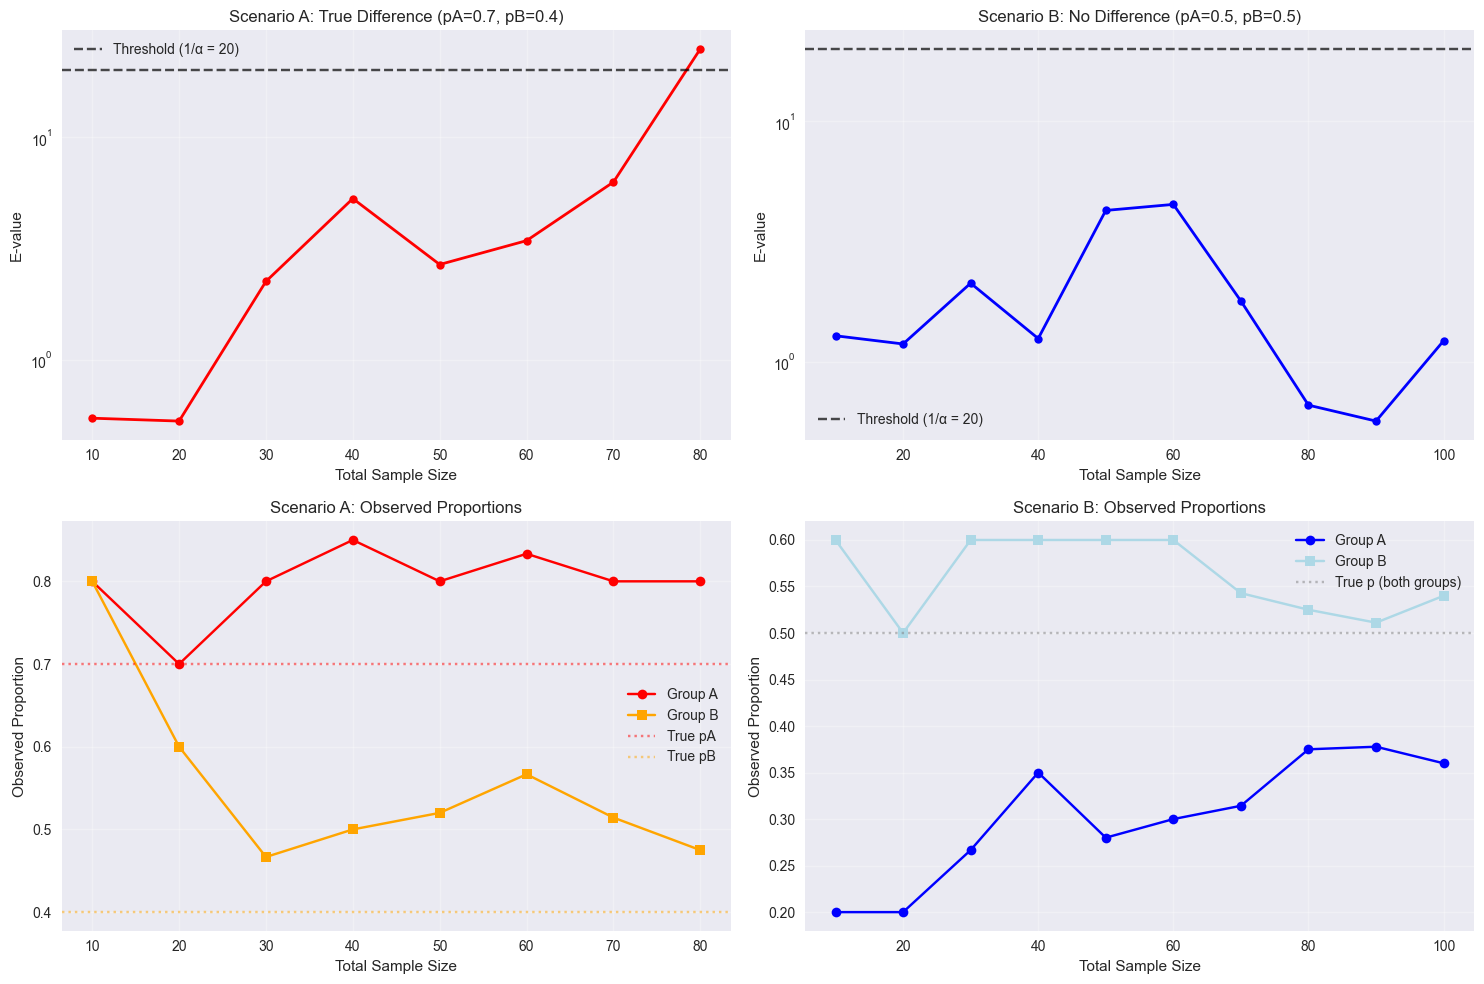

=== Summary ===
Scenario A (true difference):
  - Stopped: Yes
  - Final n: 80
  - Final E-value: 24.9

Scenario B (no difference):
  - Stopped: No
  - Final n: 100
  - Final E-value: 1.2


In [5]:
# Visualize E-value evolution over time
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Extract data from results (list of dictionaries) for plotting
total_n_A = [r["total_n"] for r in results_A]
e_values_A = [r["e_value"] for r in results_A]
pA_obs_A = [r["pA_obs"] for r in results_A]
pB_obs_A = [r["pB_obs"] for r in results_A]

total_n_B = [r["total_n"] for r in results_B]
e_values_B = [r["e_value"] for r in results_B]
pA_obs_B = [r["pA_obs"] for r in results_B]
pB_obs_B = [r["pB_obs"] for r in results_B]

# Scenario A: E-values
ax1.plot(
    total_n_A,
    e_values_A,
    "o-",
    color="red",
    linewidth=2,
    markersize=6,
)
ax1.axhline(
    y=20, color="black", linestyle="--", alpha=0.7, label="Threshold (1/α = 20)"
)
ax1.set_xlabel("Total Sample Size")
ax1.set_ylabel("E-value")
ax1.set_title("Scenario A: True Difference (pA=0.7, pB=0.4)")
ax1.set_yscale("log")
ax1.grid(True, alpha=0.3)
ax1.legend()

# Scenario B: E-values
ax2.plot(
    total_n_B,
    e_values_B,
    "o-",
    color="blue",
    linewidth=2,
    markersize=6,
)
ax2.axhline(
    y=20, color="black", linestyle="--", alpha=0.7, label="Threshold (1/α = 20)"
)
ax2.set_xlabel("Total Sample Size")
ax2.set_ylabel("E-value")
ax2.set_title("Scenario B: No Difference (pA=0.5, pB=0.5)")
ax2.set_yscale("log")
ax2.grid(True, alpha=0.3)
ax2.legend()

# Observed proportions A
ax3.plot(total_n_A, pA_obs_A, "o-", color="red", label="Group A")
ax3.plot(total_n_A, pB_obs_A, "s-", color="orange", label="Group B")
ax3.axhline(y=0.7, color="red", linestyle=":", alpha=0.5, label="True pA")
ax3.axhline(y=0.4, color="orange", linestyle=":", alpha=0.5, label="True pB")
ax3.set_xlabel("Total Sample Size")
ax3.set_ylabel("Observed Proportion")
ax3.set_title("Scenario A: Observed Proportions")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Observed proportions B
ax4.plot(total_n_B, pA_obs_B, "o-", color="blue", label="Group A")
ax4.plot(total_n_B, pB_obs_B, "s-", color="lightblue", label="Group B")
ax4.axhline(y=0.5, color="gray", linestyle=":", alpha=0.5, label="True p (both groups)")
ax4.set_xlabel("Total Sample Size")
ax4.set_ylabel("Observed Proportion")
ax4.set_title("Scenario B: Observed Proportions")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("=== Summary ===")
print(f"Scenario A (true difference):")
print(f"  - Stopped: {'Yes' if results_A[-1]['stopped'] else 'No'}")
print(f"  - Final n: {results_A[-1]['total_n']}")
print(f"  - Final E-value: {results_A[-1]['e_value']:.1f}")

print(f"\nScenario B (no difference):")
print(f"  - Stopped: {'Yes' if results_B[-1]['stopped'] else 'No'}")
print(f"  - Final n: {results_B[-1]['total_n']}")
print(f"  - Final E-value: {results_B[-1]['e_value']:.1f}")

## 4. Event Sourcing: Complete Audit Trail

One of the key advantages of EarlySign is the **complete event log** that provides full reproducibility and auditability. Let's explore the event history from our simulation.

In [6]:
# Examine the complete event log from Scenario A
events_A = list(ledger_A.reader().iter_rows(entity="scenario_A"))

print(f"Total events recorded: {len(events_A)}")
print("\n=== Event Types ===")
event_types = {}
for event in events_A:
    key = f"{event.namespace}:{event.kind}"
    event_types[key] = event_types.get(key, 0) + 1

for event_type, count in event_types.items():
    print(f"{event_type}: {count}")

# Create event timeline data (without pandas)
event_data = []
for event in events_A:
    event_data.append(
        {
            "time_index": event.time_index,
            "namespace": event.namespace,
            "kind": event.kind,
            "payload_type": event.payload_type,
            "tag": event.tag,
            "timestamp": str(event.ts),
        }
    )

print("\n=== Sample Events ===")
for i, event_info in enumerate(event_data[:10]):
    print(
        f"{i+1:2d}. {event_info['time_index']} | {event_info['namespace']:>8}:{event_info['kind']:<12} | {event_info['payload_type']}"
    )

# Demonstrate event replay capability
print("\n=== Event Replay at t002 ===")
events_up_to_t002 = [e for e in events_A if e.time_index <= "t002"]
print(f"Events up to t002: {len(events_up_to_t002)}")

# Find final statistic at t002
stat_events_t002 = [e for e in events_up_to_t002 if e.namespace == "stats"]
if stat_events_t002:
    final_stat = stat_events_t002[-1]
    print(f"E-value at t002: {final_stat.payload['e_value']:.3f}")
    print(f"Data at t002: nA={final_stat.payload['nA']}, nB={final_stat.payload['nB']}")
    print(
        f"Successes at t002: mA={final_stat.payload['mA']}, mB={final_stat.payload['mB']}"
    )

# Query events by namespace
obs_events = [e for e in events_A if e.namespace == "obs"]
stat_events = [e for e in events_A if e.namespace == "stats"]
signal_events = [e for e in events_A if e.namespace == "signals"]

print(f"\n=== Event Counts by Namespace ===")
print(f"Observations: {len(obs_events)}")
print(f"Statistics: {len(stat_events)}")
print(f"Signals: {len(signal_events)}")
print(f"Criteria: {len([e for e in events_A if e.namespace == 'criteria'])}")

Total events recorded: 32

=== Event Types ===
obs:observation: 8
stats:updated: 8
criteria:updated: 8
signals:emitted: 8

=== Sample Events ===
 1. t001 |      obs:observation  | TwoPropObsBatch
 2. t001 |    stats:updated      | BetaBinomialEValue
 3. t001 | criteria:updated      | SafeThreshold
 4. t001 |  signals:emitted      | Signal
 5. t002 |      obs:observation  | TwoPropObsBatch
 6. t002 |    stats:updated      | BetaBinomialEValue
 7. t002 | criteria:updated      | SafeThreshold
 8. t002 |  signals:emitted      | Signal
 9. t003 |      obs:observation  | TwoPropObsBatch
10. t003 |    stats:updated      | BetaBinomialEValue

=== Event Replay at t002 ===
Events up to t002: 8
E-value at t002: 0.534
Data at t002: nA=10, nB=10
Successes at t002: mA=7, mB=6

=== Event Counts by Namespace ===
Observations: 8
Statistics: 8
Signals: 8
Criteria: 8


## 5. Comparison with Traditional Methods

Let's compare the beta-binomial e-process with traditional approaches:

1. **Fixed-sample z-test**: Single analysis at predetermined sample size
2. **Group sequential test**: Multiple analyses with alpha spending
3. **Safe test**: Anytime-valid analysis with e-values

Key differences:
- **Flexibility**: Safe tests can stop at any time without penalty
- **Type I error**: Traditional methods need corrections; safe tests don't  
- **Power**: Comparable power with added flexibility
- **Interpretation**: E-values provide intuitive evidence strength

In [7]:
# Comparison at final sample sizes
def compare_methods(results_list, alpha=0.05):
    """Compare different testing methods on final data."""
    final = results_list[-1]
    nA, nB = final["nA"], final["nB"]
    mA, mB = final["mA"], final["mB"]

    # Safe test result
    e_value = final["e_value"]
    safe_significant = e_value >= 1 / alpha

    # Fixed-sample z-test
    pA_hat, pB_hat = mA / nA, mB / nB
    p_pool = (mA + mB) / (nA + nB)
    se = math.sqrt(p_pool * (1 - p_pool) * (1 / nA + 1 / nB))
    z_stat = (pB_hat - pA_hat) / se if se > 0 else 0
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    z_significant = p_value < alpha

    # Fisher's exact test
    from scipy.stats import fisher_exact

    contingency_table = [[mA, nA - mA], [mB, nB - mB]]
    _, fisher_p = fisher_exact(contingency_table, alternative="two-sided")
    fisher_significant = fisher_p < alpha

    return {
        "method": ["Safe Test", "Z-Test", "Fisher's Exact"],
        "statistic": [f"E = {e_value:.2f}", f"Z = {z_stat:.2f}", f"p = {fisher_p:.4f}"],
        "p_value": ["N/A (uses E-value)", f"{p_value:.4f}", f"{fisher_p:.4f}"],
        "significant": [safe_significant, z_significant, fisher_significant],
        "threshold": [f"E ≥ {1/alpha:.0f}", f"p < {alpha}", f"p < {alpha}"],
        "anytime_valid": [True, False, False],
    }


def print_comparison_table(comparison_dict):
    """Print comparison results in table format."""
    methods = comparison_dict["method"]
    statistics = comparison_dict["statistic"]
    p_values = comparison_dict["p_value"]
    significants = comparison_dict["significant"]
    thresholds = comparison_dict["threshold"]
    anytime_valids = comparison_dict["anytime_valid"]

    print(
        f"{'Method':<15} {'Statistic':<15} {'P-value':<20} {'Significant':<12} {'Threshold':<12} {'Anytime Valid':<12}"
    )
    print("-" * 95)
    for i in range(len(methods)):
        sig_str = "Yes" if significants[i] else "No"
        anytime_str = "Yes" if anytime_valids[i] else "No"
        print(
            f"{methods[i]:<15} {statistics[i]:<15} {p_values[i]:<20} {sig_str:<12} {thresholds[i]:<12} {anytime_str:<12}"
        )


# Compare methods for both scenarios
print("=== Scenario A: True Difference ===")
comparison_A = compare_methods(results_A)
print_comparison_table(comparison_A)

print("\n=== Scenario B: No Difference ===")
comparison_B = compare_methods(results_B)
print_comparison_table(comparison_B)

# Stopping time comparison
print(f"\n=== Stopping Time Analysis ===")
print(f"Scenario A (true difference):")
if results_A[-1]["stopped"]:
    stopped_results_A = [r for r in results_A if r["stopped"]]
    if stopped_results_A:
        stop_result = stopped_results_A[0]
        print(
            f"  Safe test stopped early at n={stop_result['total_n']} (step {stop_result['step']})"
        )
else:
    print(f"  Safe test did not stop early (final n={results_A[-1]['total_n']})")

print(f"  Traditional methods would use full sample: n={results_A[-1]['total_n']}")

print(f"\nScenario B (no difference):")
if results_B[-1]["stopped"]:
    stopped_results_B = [r for r in results_B if r["stopped"]]
    if stopped_results_B:
        stop_result = stopped_results_B[0]
        print(
            f"  Safe test stopped early at n={stop_result['total_n']} (step {stop_result['step']})"
        )
else:
    print(f"  Safe test did not stop early (final n={results_B[-1]['total_n']})")

print(f"  Traditional methods would use full sample: n={results_B[-1]['total_n']}")

=== Scenario A: True Difference ===
Method          Statistic       P-value              Significant  Threshold    Anytime Valid
-----------------------------------------------------------------------------------------------
Safe Test       E = 24.91       N/A (uses E-value)   Yes          E ≥ 20       Yes         
Z-Test          Z = -3.02       0.0025               Yes          p < 0.05     No          
Fisher's Exact  p = 0.0048      0.0048               Yes          p < 0.05     No          

=== Scenario B: No Difference ===
Method          Statistic       P-value              Significant  Threshold    Anytime Valid
-----------------------------------------------------------------------------------------------
Safe Test       E = 1.22        N/A (uses E-value)   No           E ≥ 20       Yes         
Z-Test          Z = 1.81        0.0704               No           p < 0.05     No          
Fisher's Exact  p = 0.1074      0.1074               No           p < 0.05     No          

## 6. Type I Error Validation

Let's empirically verify that safe tests maintain the promised Type I error rate even with optional stopping.

In [8]:
# Simulate many experiments under null hypothesis
def simulate_type_I_error(n_simulations=500, p_null=0.5, alpha=0.05):
    """Simulate Type I error rate under null hypothesis."""

    false_positives = 0
    early_stops = 0

    for sim in range(n_simulations):
        # Run simulation under null (both groups have same probability)
        results, _ = simulate_sequential_experiment(
            pA=p_null,
            pB=p_null,
            max_per_group=30,
            batch_size=3,
            experiment_name=f"sim_{sim}",
        )

        # Check if we declared significance
        final_e_value = results.iloc[-1]["e_value"]
        if final_e_value >= 1 / alpha:
            false_positives += 1

        # Check if we stopped early
        if results.iloc[-1]["stopped"]:
            early_stops += 1

    empirical_alpha = false_positives / n_simulations
    early_stop_rate = early_stops / n_simulations

    return empirical_alpha, early_stop_rate


print("Running Type I error simulation (this may take a minute)...")
empirical_alpha, early_stop_rate = simulate_type_I_error(n_simulations=200)

print(f"=== Type I Error Validation ===")
print(f"Theoretical α: {0.05:.3f}")
print(f"Empirical α: {empirical_alpha:.3f}")
print(f"Difference: {abs(empirical_alpha - 0.05):.3f}")
print(f"Early stop rate: {early_stop_rate:.1%}")

# Check if within expected range (with some simulation variance)
se_alpha = math.sqrt(0.05 * 0.95 / 200)  # Standard error for binomial
ci_lower = 0.05 - 1.96 * se_alpha
ci_upper = 0.05 + 1.96 * se_alpha

print(f"\n95% CI for α: [{ci_lower:.3f}, {ci_upper:.3f}]")
print(
    f"Within expected range: {'✓' if ci_lower <= empirical_alpha <= ci_upper else '✗'}"
)

if empirical_alpha <= 0.05:
    print("✅ Type I error rate is controlled!")
else:
    print("⚠️  Type I error rate may be inflated")

Running Type I error simulation (this may take a minute)...
🛑 Stopped at step 4 (n=24) with E=32.6


AttributeError: 'list' object has no attribute 'iloc'

## 7. Practical Guidelines

### When to Use Beta-Binomial E-Process

**✅ Good for:**
- Comparing success rates between two groups
- Need for flexible stopping times  
- Regulatory contexts requiring audit trails
- Continuous monitoring scenarios
- Small to moderate sample sizes

**⚠️ Consider alternatives when:**
- Large sample sizes (may be conservative)
- Complex experimental designs with many factors
- Prior information strongly contradicts beta priors

### Parameter Selection

**Alpha/Beta Priors:**
- `(1,1)`: Uniform/uninformative (default)
- `(0.5,0.5)`: Jeffrey's prior (often better properties)  
- `(a,b)` with a,b > 1: Informative priors when you have domain knowledge

**Significance Level:**
- α = 0.05: Standard choice (threshold = 20)
- α = 0.01: More stringent (threshold = 100) 
- α = 0.10: More liberal (threshold = 10)

### Implementation Tips

1. **Start conservatively**: Use uninformative priors initially
2. **Monitor frequently**: Check e-values as data arrives
3. **Document decisions**: Event log provides complete audit trail
4. **Plan stopping rules**: Decide maximum sample size in advance
5. **Consider power**: Run simulations to estimate required sample sizes

## 8. Summary

The **beta-binomial e-process** in EarlySign provides:

🎯 **Anytime-valid inference** without multiple testing corrections
📊 **Intuitive interpretation** via e-values as evidence strength  
🔍 **Complete audit trail** through event-sourcing architecture
⚡ **Early stopping** potential for efficiency gains
🛡️ **Exact Type I error control** with flexible stopping

### Key Advantages

- **Regulatory friendly**: Complete documentation and reproducibility
- **Flexible timing**: Stop when sufficient evidence is available
- **Robust inference**: Beta-binomial model handles overdispersion
- **Composable design**: Integrate with other EarlySign components

### Next Steps

- Explore **adaptive priors** for improved power
- Try **multi-arm** comparisons with safe testing  
- Implement **futility boundaries** for early stopping
- Combine with **Bayesian posterior** analysis

The combination of **safe testing** and **event sourcing** opens new possibilities for principled, auditable, and efficient sequential analysis! 🚀